In [1]:
import cudf
import sys
import scanpy as sc
import scFates as scf
sys.path.append("../ConceptFates/")
sc.settings.verbosity=3
sc.set_figure_params(dpi=150)

import gpu_wrappers
import rapids_scanpy_funcs as rap

In [2]:
import pandas as pd


In [3]:
adata=gpu_wrappers.load_mtx("ML6-7/scenic/")


In [10]:
adata.var["Gene"]=adata.var_names
adata.obs["CellID"]=adata.obs_names

In [11]:
adata.write_loom("ML6-7/scenic/adata.loom")

In [4]:
adata.obs["leiden"]=pd.read_table("ML6-7/leiden.tsv",header=None)[0].values.astype(str)

In [5]:
adata.obs["batch"]=list(map(lambda n: n.split("_")[0], adata.obs_names))


In [6]:
adata.obs.batch=adata.obs.batch.astype("category")
adata.obs.leiden=adata.obs.leiden.astype("category")

In [7]:
import proportion_test

In [8]:
prop_res = proportion_test.proportion_test(adata,"batch","leiden","ML6","ML7",
                      n_permutations=10000,n_jobs=10)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 10000/10000 [00:11<00:00, 853.25it/s]
/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [9]:
prop_res

,ML6,ML7,obs_log2FD,pval,fdr,boot_mean_log2FD,boot_CI_2.5,boot_CI_97.5,significance
clusters,,,,,,,,,
1,0.304450,0.291703,-0.061705,0.121188,0.196930,-0.061994,-0.160401,0.035714,n.s.
10,0.005600,0.006620,0.241377,0.332567,0.332567,0.248260,-0.598159,1.134955,n.s.
11,0.053345,0.057811,0.115991,0.203380,0.261274,0.116340,-0.147192,0.384607,n.s.
12,0.006189,0.004634,-0.417586,0.208779,0.261274,-0.422406,-1.343758,0.489445,n.s.
13,0.006779,0.012798,0.916833,0.004400,0.011266,0.931978,0.234490,1.679275,FDR < 0.05 & abs(Log2FD) > 0.58
14,0.003242,0.004634,0.515299,0.221078,0.261274,inf,-0.517122,1.719917,n.s.
2,0.103743,0.122683,0.241923,0.005199,0.011266,0.243266,0.056782,0.425617,n.s.
3,0.068671,0.053619,-0.356960,0.003000,0.009749,-0.356127,-0.606164,-0.107902,n.s.
4,0.083996,0.080097,-0.068579,0.279072,0.302328,-0.069472,-0.282235,0.142415,n.s.


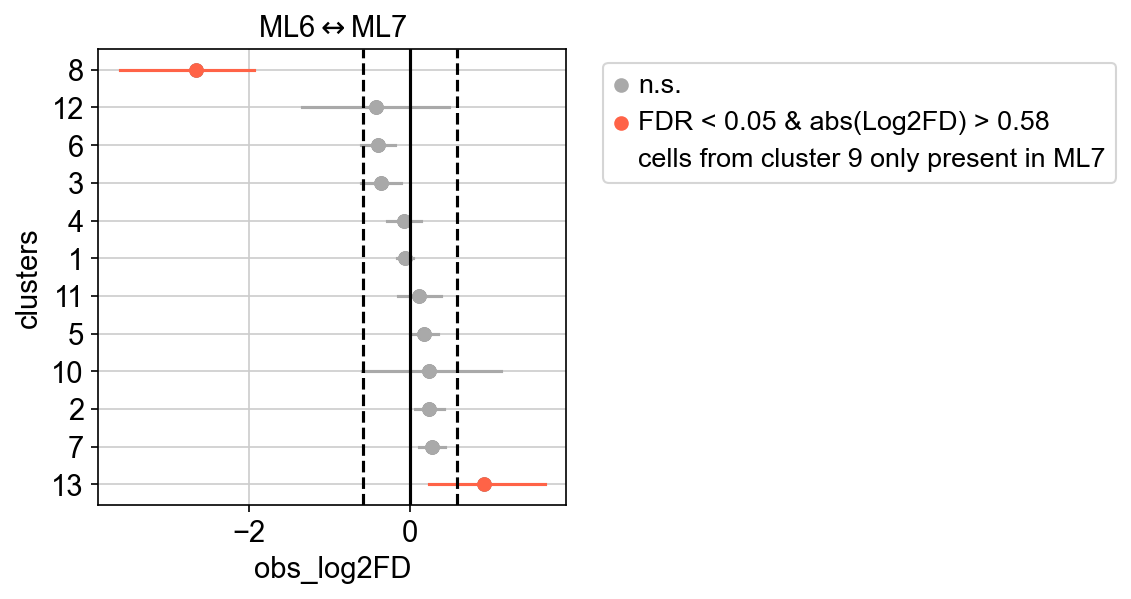

In [23]:
import imp
imp.reload(proportion_test)

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
proportion_test.plot_proportion_test(prop_res)

In [27]:
prop_res.to_csv("ML6-7/perm_test_res_ML6-7.csv")

In [24]:
res=pd.DataFrame(0,index=adata.obs.batch.cat.categories,columns=adata.obs.leiden.cat.categories)
res=pd.concat(list(map(lambda b: (adata.obs.loc[adata.obs.batch==b,"leiden"].value_counts()/(adata.obs.batch==b).sum())*100,
         adata.obs.batch.cat.categories)),axis=1)
res.columns=adata.obs.batch.cat.categories

totals=pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T

res.index = res.index.astype(str)

res = pd.concat([res,pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T],axis=0)
res.loc["total"]=res.loc["total"].astype(int)

In [26]:
res.to_csv("ML6-7/prop_totals.csv")